## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-01 13:18:50--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  17.3MB/s    in 0.3s    

2025-03-01 13:18:51 (17.3 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLe

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
  '''
  По строкам матрицы - пользователи, по стол-
  бцам - фильмы. Значения в матрице - рейтинг
  фильма, если его нет, то 0.
  '''
  cnt_users = df['user_id'].nunique()
  cnt_item = df['item_id'].nunique()

  result = np.zeros((cnt_users, cnt_item))

  user_id = df['user_id'].values
  item_id = df['item_id'].values
  rating = df['rating'].values

  result[user_id, item_id] = rating

  return result

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array, csr_matrix

def df_to_coo(df: pd.DataFrame) -> coo_array:
  '''
  Матрица в формате COO: сохраняем только
  ненулевые элементы и их координаты
  '''
  cnt_users = df['user_id'].nunique()
  cnt_item = df['item_id'].nunique()

  user_id = df['user_id'].values
  item_id = df['item_id'].values
  rating = df['rating'].values

  result = coo_array((rating, (user_id, item_id)), shape=(cnt_users, cnt_item))

  return result

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from scipy.sparse.linalg import svds

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    if isinstance(interactions, coo_array):
        interactions = interactions.astype(float).tocsr()

        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1

        U, S, Vt = svds(interactions, k=n_singular_values)
        S = np.diag(S)

    elif isinstance(interactions, np.ndarray):
        interactions = interactions.astype(float)
        U, S, Vt = np.linalg.svd(interactions, full_matrices=False)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = np.diag(S[:n_singular_values])
            Vt = Vt[:n_singular_values, :]
        else:
            S = np.diag(S)

    else:
        raise TypeError("Unsupported matrix type. Must be np.ndarray or scipy.sparse.coo_array")

    return U, S, Vt

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
from scipy.sparse import issparse

def make_svd_recommendations(
    interactions: Union[np.ndarray, coo_array, csr_matrix],
    n_singular_values: int = -1,
    top_k: int = 100,
):

    if issparse(interactions):
        interactions = interactions.astype(float).toarray()

    U, S, Vt = np.linalg.svd(interactions, full_matrices=False)

    if n_singular_values != -1:
        U = U[:, :n_singular_values]
        S = np.diag(S[:n_singular_values])
        Vt = Vt[:n_singular_values, :]
    else:
        S = np.diag(S)

    predicted_scores = U @ S @ Vt

    known_interactions = interactions.astype(bool)
    predicted_scores[known_interactions] = -np.inf

    recommendations = np.argsort(-predicted_scores, axis=1)[:, :top_k]

    return recommendations

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [19]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

def calculate_ndcg(test_df, recommendations, top_k):
    '''
    Вычисляем метрику NDCG для тестового датасета и рекомендаций
    '''
    ndcg_scores = []
    for user_id in range(recommendations.shape[0]):
        true_items = test_df[test_df['user_id'] == user_id]['item_id'].values
        if len(true_items) == 0:
            continue
        pred_items = recommendations[user_id]
        true_relevance = np.isin(pred_items, true_items).astype(int)
        ideal_relevance = np.sort(true_relevance)[::-1]
        ndcg_scores.append(ndcg_score([true_relevance], [ideal_relevance], k=top_k))
    return np.mean(ndcg_scores)

def plot_graphs(train_df: pd.DataFrame, test_df: pd.DataFrame, top_k: int = 100):
    n_singular_values_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    execution_times = []

    all_items = pd.unique(pd.concat([train_df['item_id'], test_df['item_id']])).tolist()
    all_items.sort()

    interactions = train_df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
    interactions = interactions.reindex(columns=all_items, fill_value=0).values

    for n_singular_values in n_singular_values_list:
        start_time = time.time()
        recommendations = make_svd_recommendations(interactions, n_singular_values, top_k)
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

        ndcg = calculate_ndcg(test_df, recommendations, top_k)
        ndcg_scores.append(ndcg)

        print(f"n_singular_values: {n_singular_values}, NDCG: {ndcg}, Time: {execution_time}")


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(n_singular_values_list, ndcg_scores, marker='o')
    plt.xlabel('n_singular_values')
    plt.ylabel('NDCG')
    plt.title('NDCG vs n_singular_values')

    plt.subplot(1, 2, 2)
    plt.plot(n_singular_values_list, execution_times, marker='o')
    plt.xlabel('n_singular_values')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time vs n_singular_values')

    plt.tight_layout()
    plt.show()

n_singular_values: 1, NDCG: 0.4828999441784038, Time: 49.31136965751648
n_singular_values: 10, NDCG: 0.5145407168219976, Time: 49.66312098503113
n_singular_values: 50, NDCG: 0.4983858489234908, Time: 49.590137243270874
n_singular_values: 200, NDCG: 0.4431266724573158, Time: 50.3601770401001
n_singular_values: 1000, NDCG: 0.2845740757963632, Time: 51.98240399360657


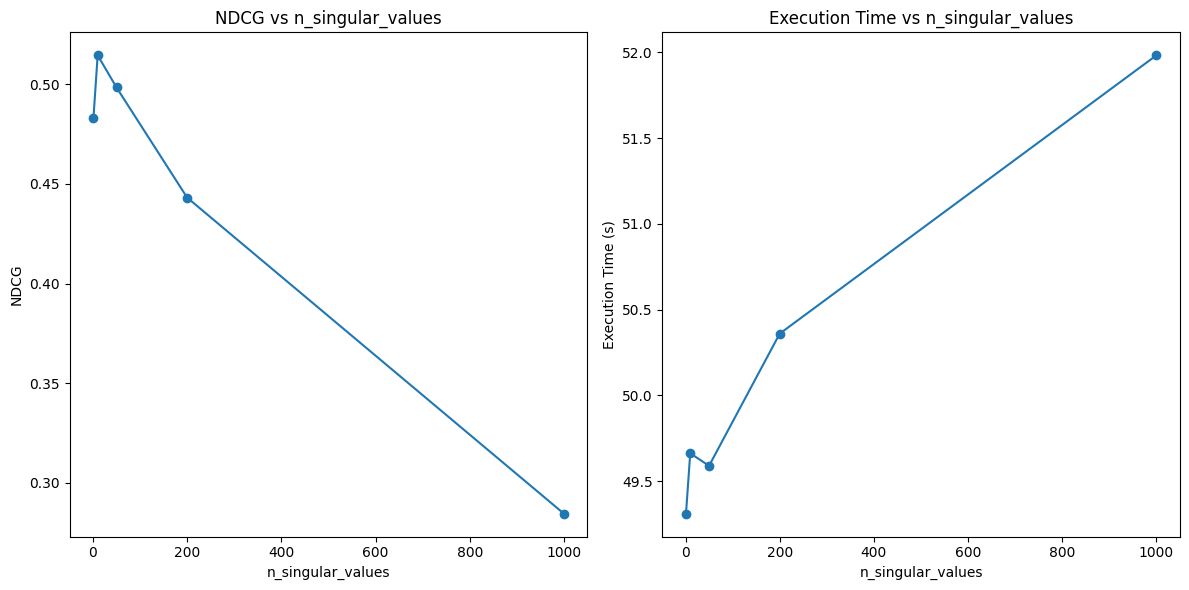

In [20]:
plot_graphs(df_train, df_test)

>Оптимальное значение n_singular_values - 10, увеличение числа сингулярных компонент сверх этого значения не улучшает качество рекомендаций, а только ухудшает его. Максимальное значение метрики достигается достаточно при небольшом значение сингулярных компомонент, это может быть связано с тем, что первые несколько сингулярных чисел обычно соответствуют наиболее значимым латентным факторам, которые объясняют основную информацию о предпочтениях пользователей. Большие значения сингулярных компонент могут соответствовать менее значимым или шумовым компонентам.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [21]:
!pip install implicit

In [22]:
import numpy as np
from implicit.als import AlternatingLeastSquares

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if not isinstance(interactions, coo_array):
        interactions = coo_array(interactions)

    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha,
        iterations=20,
        random_state=42,
    )
    model.fit(interactions)

    user_factors = model.user_factors
    item_factors = model.item_factors
    predicted_scores = user_factors @ item_factors.T

    known_interactions = interactions.astype(bool).toarray()
    predicted_scores[known_interactions] = -np.inf

    recommendations = np.argsort(-predicted_scores, axis=1)[:, :top_k]

    return recommendations, model

In [23]:
csr_interactions = csr_matrix(coo_interactions)

als_recommendations, als_model = make_als_recommendations(
    csr_interactions,
    top_k=100,
    n_factors=100,
    alpha=1.0,
    regularization=0.01,
)

svd_recommendations = make_svd_recommendations(
    csr_interactions,
    n_singular_values=10,
    top_k=100,
)

als_ndcg = calculate_ndcg(df_test, als_recommendations, top_k=100)
svd_ndcg = calculate_ndcg(df_test, svd_recommendations, top_k=100)

print(f"ALS NDCG: {als_ndcg}")
print(f"SVD NDCG: {svd_ndcg}")

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.005855083465576172 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

ALS NDCG: 0.476916992285869
SVD NDCG: 0.5145407168219976


>Без подбора гиперпараметров SVD показал более высокое качество рекомендаций с метрикой NDCG ~ 0.52. ALS показал результат чуть худше - NDCG ~ 0.48.

In [24]:
recs, model = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.005053043365478516 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [25]:
movies_df = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', encoding="latin1", names=["MovieID", "Title", "Genres"])

In [26]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
item_id_to_title = dict(zip(movies_df["MovieID"], movies_df["Title"]))

>Выведим рекомендации фильмов для пяти случайных пользователей, а также, отобразим какие фильмы повлияли на рекомендацию:

In [28]:
def explain_recommendations(user_ids, model, interactions, recommendations, item_id_to_title, top_k=5):

    for user_id in user_ids:
        print(f"\nОбъяснение рекомендаций для пользователя {user_id}:")
        user_recommendations = recommendations[user_id][:top_k]

        for item_id in user_recommendations:
            explanation = model.explain(user_id, interactions, item_id)

            item_title = item_id_to_title.get(item_id, "Неизвестный фильм")

            print(f"\nФильм: {item_title} (ID: {item_id})")
            print("Фильмы, которые повлияли на рекомендацию:")

            for influenced_item_id, weight in explanation[1]:
                influenced_item_title = item_id_to_title.get(influenced_item_id, "Неизвестный фильм")
                print(f"  - {influenced_item_title} (ID: {influenced_item_id}, Вес: {weight:.4f})")

csr_interactions = csr_matrix(coo_interactions)
np.random.seed(42)
random_user_ids = np.random.choice(csr_interactions.shape[0], size=5, replace=False)

explain_recommendations(random_user_ids, model, csr_interactions, recs, item_id_to_title)


Объяснение рекомендаций для пользователя 5062:

Фильм: Неизвестный фильм (ID: 1691)
Фильмы, которые повлияли на рекомендацию:
  - In the Name of the Father (1993) (ID: 475, Вес: 0.0563)
  - Men With Guns (1997) (ID: 1788, Вес: 0.0482)
  - Turning, The (1992) (ID: 1524, Вес: 0.0479)
  - Soul Man (1986) (ID: 2473, Вес: 0.0477)
  - Father of the Bride Part II (1995) (ID: 5, Вес: 0.0440)
  - Magic Hunter (1994) (ID: 812, Вес: 0.0339)
  - Goofy Movie, A (1995) (ID: 239, Вес: 0.0334)
  - Barcelona (1994) (ID: 417, Вес: 0.0321)
  - George of the Jungle (1997) (ID: 1588, Вес: 0.0319)
  - Frank and Ollie (1995) (ID: 398, Вес: 0.0318)

Фильм: Gigi (1958) (ID: 938)
Фильмы, которые повлияли на рекомендацию:
  - Liebelei (1933) (ID: 894, Вес: 0.1307)
  - Craft, The (1996) (ID: 724, Вес: 0.0482)
  - This World, Then the Fireworks (1996) (ID: 2008, Вес: 0.0473)
  - Maximum Overdrive (1986) (ID: 2119, Вес: 0.0415)
  - Ninotchka (1939) (ID: 936, Вес: 0.0409)
  - For Whom the Bell Tolls (1943) (ID: 897

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [29]:
def transform_ratings(df: pd.DataFrame, method: str) -> pd.DataFrame:
    if method == "binary_all":
        df['rating'] = 1
    elif method == "binary_4_5_zero":
        df['rating'] = np.where(df['rating'] >= 4, 1, 0)
    elif method == "binary_4_5_neg":
        df['rating'] = np.where(df['rating'] >= 4, 1, -1)
    elif method == "binary_4_5_neg_time_decay":
        df['rating'] = np.where(df['rating'] >= 4, 1, -1)
        max_date = df['datetime'].max()
        df['days_diff'] = (max_date - df['datetime']).dt.days
        decay_rate = 0.1
        df['rating'] *= np.exp(-decay_rate * df['days_diff'])
    else:
        raise ValueError("Unknown method")
    return df

In [30]:
df_test_filtered = df_test[
    df_test['user_id'].isin(df_train['user_id'].unique()) &
    df_test['item_id'].isin(df_train['item_id'].unique())
]

methods = [
    "binary_all",  # 1
    "binary_4_5_zero",  # 2
    "binary_4_5_neg",  # 3
    "binary_4_5_neg_time_decay" # 4
]

results = {}

for method in methods:
    print(f"\nПреобразование данных: {method}")

    df_train_transformed = transform_ratings(df_train.copy(), method)
    coo_interactions_transformed = df_to_coo(df_train_transformed)

    als_recommendations, als_model = make_als_recommendations(
        coo_interactions_transformed,
        top_k=100,
        n_factors=100,
        alpha=1.0,
        regularization=0.01)

    svd_recommendations = make_svd_recommendations(
        coo_interactions_transformed,
        n_singular_values=10,
        top_k=100)

    als_ndcg = calculate_ndcg(df_test_filtered, als_recommendations, top_k=100)
    svd_ndcg = calculate_ndcg(df_test_filtered, svd_recommendations, top_k=100)

    results[method] = {"ALS NDCG": als_ndcg, "SVD NDCG": svd_ndcg}

for method, metrics in results.items():
    print(f"\nМетод: {method}")
    print(f"ALS NDCG: {metrics['ALS NDCG']}")
    print(f"SVD NDCG: {metrics['SVD NDCG']}")


Преобразование данных: binary_all


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0365290641784668 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]


Преобразование данных: binary_4_5_zero


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03609418869018555 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]


Преобразование данных: binary_4_5_neg


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03596973419189453 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]


Преобразование данных: binary_4_5_neg_time_decay


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04730415344238281 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]


Метод: binary_all
ALS NDCG: 0.47630145186541645
SVD NDCG: 0.5022227216385845

Метод: binary_4_5_zero
ALS NDCG: 0.3971804820576986
SVD NDCG: 0.4811894891772174

Метод: binary_4_5_neg
ALS NDCG: 0.4796527795060373
SVD NDCG: 0.5020131154203998

Метод: binary_4_5_neg_time_decay
ALS NDCG: 0.4804716771117899
SVD NDCG: 0.4766919718089815


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [31]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):

        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):

        n_users, n_items = interactions.shape

        self.user_factors = np.random.rand(n_users, self.n_factors) * 0.01
        self.item_factors = np.random.rand(n_items, self.n_factors) * 0.01

        binary_interactions = (interactions > 0).astype(float)
        weighted_interactions = 1 + self.alpha * interactions

        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")

            for u in range(n_users):
                items_u = np.where(binary_interactions[u] > 0)[0]  # индексы айтемов, с которыми взаимодействовал пользователь u
                if len(items_u) == 0:
                    continue

                A_u = np.dot(self.item_factors[items_u].T, self.item_factors[items_u] * weighted_interactions[u, items_u][:, np.newaxis])
                A_u += self.reg_coef * np.eye(self.n_factors)
                b_u = np.dot(self.item_factors[items_u].T, weighted_interactions[u, items_u])

                self.user_factors[u] = np.linalg.solve(A_u, b_u)

            for i in range(n_items):
                users_i = np.where(binary_interactions[:, i] > 0)[0]  # индексы пользователей, которые взаимодействовали с айтемом i
                if len(users_i) == 0:
                    continue

                A_i = np.dot(self.user_factors[users_i].T, self.user_factors[users_i] * weighted_interactions[users_i, i][:, np.newaxis])
                A_i += self.reg_coef * np.eye(self.n_factors)
                b_i = np.dot(self.user_factors[users_i].T, weighted_interactions[users_i, i])

                self.item_factors[i] = np.linalg.solve(A_i, b_i)

    def predict(self, top_k: int = 100):
        n_users = self.user_factors.shape[0]
        predicted_scores = np.dot(self.user_factors, self.item_factors.T)
        predicted_scores[predicted_scores == 0] = -np.inf
        predicts = np.argsort(-predicted_scores, axis=1)[:, :top_k]

        return predicts

In [32]:
ials = iALS(n_factors=100, alpha=1.0, reg_coef=0.01)
ials.fit(interactions, n_iterations=10)
recommendations_custom = ials.predict(top_k=10)

ndcg_custom = calculate_ndcg(df_test, recommendations_custom, top_k=100)

print(f"NDCG (custom iALS): {ndcg_custom}")

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
NDCG (custom iALS): 0.1228809764703263
